In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    return F

# Call the make filter function
F = makeLMfilters()
print (F.shape)

(49, 49, 48)


In [8]:
import cv2
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

In [9]:
import numpy as np
def split_image(img):
    [m,n] = img.shape
    x = n//5
    img1 = img[:,0:x]
    img2 = img[:,x:2*x]
    img3 = img[:,2*x:3*x]
    img4 = img[:,3*x:4*x]
    img5 = img[:,4*x:5*x]
    return [img1,img2,img3,img4,img5]

In [10]:
def preprocess_image(img):
    splitted = split_image(img)
    out=[]
    for k in splitted:
        k = cv2.equalizeHist(k)
        k = cv2.resize(k,(120,120))
        k = cv2.GaussianBlur(k,(5,5),2)
        out.append(k)
    return out

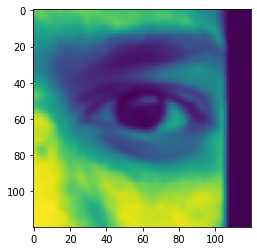

In [11]:
x = read_image('Downloads/1144_l_1.png')
im_list = preprocess_image(x)
plt.imshow(im_list[2])

In [12]:
out = []
for img in im_list:
    k = np.zeros((120,120,48))
    for i in range(0,47):
        k[:,:,i] = cv2.filter2D(img, -1, F[:,:,i])
    out.append(k)    

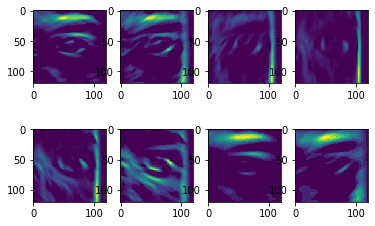

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
e=0
for i in range(1,3):
    for j in range(1,5):
        plt.subplot(2,4,e+1)
        plt.imshow(out[1][:,:,e])
        e+=1

In [14]:
'''
Dataset description
Images of 550 persons from different angles

'''
dataset_directory = '.../VISOB2/input'



In [15]:
# Importing modules to create our layers and model.
from keras.layers import Input, Dense
from keras.models import Model

In [16]:
#corresponding to one image in dataset, there are 5 images that need to be separated. and for each of them, 
#there will be 48 images of their features. so 5*48 images will be there for one image in dataset.

encoding_dim = 36
input_img = Input(shape=(120*120*48, ))
# This is the size of the output. We want to generate 28 x 28 pictures in the end, so this is the size we're looking for. 
output_dim = 120*120*48
encoded1 = Dense(encoding_dim, activation='relu')(input_img)
decoded1 = Dense(output_dim, activation='sigmoid')(encoded1)
encoded2 = Dense(encoding_dim, activation='relu')(decoded1)
decoded2 = Dense(output_dim, activation='sigmoid')(encoded2)
encoded3 = Dense(encoding_dim, activation='relu')(decoded2)
decoded3 = Dense(output_dim, activation='sigmoid')(encoded3)
encoded4 = Dense(encoding_dim, activation='relu')(decoded3)
decoded4 = Dense(output_dim, activation='sigmoid')(encoded4)
output = Dense(550,activation='softmax')(decoded4)

ResourceExhaustedError: OOM when allocating tensor with shape[691200,550] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add] name: dense_18/random_uniform/

In [4]:
autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 691200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                24883236  
_________________________________________________________________
dense_2 (Dense)              (None, 691200)            25574400  
_________________________________________________________________
dense_3 (Dense)              (None, 36)                24883236  
_________________________________________________________________
dense_4 (Dense)              (None, 691200)            25574400  
_________________________________________________________________
dense_5 (Dense)              (None, 36)                24883236  
_________________________________________________________________
dense_6 (Dense)              (None, 691200)            2557

In [6]:
for i in range(0,5):
    img = out[i].reshape((120*120*48))

NameError: name 'out' is not defined

In [ ]:
import cv2
img1 = cv2.imread('Downloads/1144_l_1.png')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1 = img1[:,:222]

In [ ]:
img1.shape

In [ ]:
img1 = cv2.resize(img1,(28,28))

In [ ]:
img1 = img1.reshape((784))

In [ ]:
img1.shape

In [ ]:
autoencoder.fit(np.expand_dims(img1,axis=0), np.expand_dims(img1,axis=0), epochs=15)

In [ ]:
img2 = cv2.imread('IMG_20190728_125759282_HDR.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2 = cv2.resize(img2,(28,28))
img2 = img2.reshape((784))
img2.shape

In [ ]:
decoded_images = autoencoder.predict(np.expand_dims(img1,axis=0))

In [ ]:
decoded_images.shape

In [ ]:
decoded_images = decoded_images.reshape((28,28))

In [ ]:
plt.imshow(decoded_images)

In [ ]:
encoder = Model(input_img, encoded)

In [ ]:
encoder.compile(optimizer='adadelta', loss='binary_crossentropy')